# **TCGA Hyperparameter search**



# **Imports**

In [525]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import scipy
import anndata as ad


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from sklearn.model_selection import train_test_split


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [526]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/pseudobulks/"
res_data_path = f"{os.getcwd()}/../results/buddiM2_tcga/"

cfdna_file = f"{os.getcwd()}/../data/cfDNA/cfdna_processed_all.h5ad"

regions_path = f"{os.getcwd()}/../data/reference/TCGA_regions.csv"


num_genes = 7000

exp_id = "all-tcga"
res_id = "all-tcga"

RETRAIN_MODELS = False


# Set-up experimental variables

In [527]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 13

# number of patients/domains/samples expected
n_tot_samples = 531 # all TCGA samples 525 + cfdna 6

# number of drugs 
# one-hot encoded
n_drugs = 8

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [528]:
# read cfDNA in
cfdna_adata = ad.read_h5ad(cfdna_file)
cfdna_adata = cfdna_adata[cfdna_adata.obs.cancer_type != "LIHC"]

cfdna_test = cfdna_adata[[0,1,8]]
cfdna_adata = cfdna_adata[2:8]

sc.pp.normalize_total(cfdna_adata, target_sum=1e7) 


# format counts into dataframe
cfdna_X = pd.DataFrame(cfdna_adata.X.todense())
cfdna_X.columns = cfdna_adata.var.gene_ids

# make metadata table
meta_cfdna = cfdna_adata.obs
meta_cfdna = meta_cfdna[["sample_id", "cancer_type"]]
meta_cfdna["isTraining"] = "Train"
meta_cfdna["num_blood"] = 0
meta_cfdna["samp_type"] = "bulk"


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [529]:
cfdna_X

gene_ids  chr1:17238-17739  chr1:817118-817619  chr1:826524-827025  \
0                15.049328           86.888573           74.678741   
1                25.361139           60.119488          138.014420   
2                22.255302           45.527988           79.483223   
3                46.447590           55.396210          120.309204   
4                 3.543494           56.051624           72.641617   
5                15.832536           57.879597           88.766022   

gene_ids  chr1:827303-827804  chr1:830679-831180  chr1:877099-877600  \
0                  48.129456           69.709625          147.227859   
1                 109.256699           94.538177          133.032761   
2                  63.713753           76.303894          180.967407   
3                  97.440514          119.741035          126.416992   
4                  50.736385           96.962868          151.564880   
5                  79.032906           80.849754           45.031883   

gene_ids  chr1:920320-920821  chr1:925423-925924  chr1:929911-930412  \
0                 161.851257           93.703362          180.166016   
1                 141.750656          156.242737          147.864502   
2                 228.911682          105.426544          199.407501   
3                 181.955246          110.366295          242.322906   
4                 249.010956          154.625168          158.329727   
5                 218.021805           92.399719          152.485489   

gene_ids  chr1:938609-939110  ...  chrX:155264243-155264744  \
0                 187.832657  ...                221.480682   
1                 188.283813  ...                353.244446   
2                 218.737823  ...                167.868561   
3                 159.370636  ...                285.077423   
4                 161.067886  ...                220.663010   
5                 164.684326  ...                155.729858   

gene_ids  chrX:155334487-155334988  chrX:155334996-155335497  \
0                       255.554626                273.869385   
1                       325.279266                295.502563   
2                       352.269653                328.106750   
3                       296.724823                269.594879   
4                       234.836975                255.292603   
5                       171.302841                186.875839   

gene_ids  chrX:155612717-155613218  chrX:155766937-155767438  \
0                       187.122772                187.406723   
1                       153.299026                321.543030   
2                       270.115784                346.038147   
3                       292.889709                234.368576   
4                       184.583801                305.062592   
5                       117.316498                256.954254   

gene_ids  chrX:155767443-155767944  chrX:155880523-155881024  \
0                       176.048737                226.875717   
1                       296.747986                219.645584   
2                       272.277740                207.165070   
3                       198.716141                294.878296   
4                       260.929993                231.132416   
5                       252.671692                305.100739   

gene_ids  chrX:155881036-155881537  chrX:156003787-156004288  \
0                       221.196732                231.418915   
1                       183.415390                257.913727   
2                       175.626129                157.313187   
3                       270.873260                151.984467   
4                       210.354660                205.200485   
5                       258.381805                197.647141   

gene_ids  chrX:156005167-156005668  
0                       212.252319  
1                       217.154755  
2                       202.078140  
3                       163.773926  
4                       238.541550  
5                       247.221146  

[

In [530]:
meta_cfdna

sample_id cancer_type isTraining  num_blood samp_type
BRCA_IC46 -1-0-0-0-0-0  BRCA_IC46         BRCA      Train          0      bulk
BRCA_IC34 -1-0-0-0-0    BRCA_IC34         BRCA      Train          0      bulk
BRCA_IC12 -1-0-0-0      BRCA_IC12         BRCA      Train          0      bulk
BRCA_IC04 -1-0-0        BRCA_IC04         BRCA      Train          0      bulk
LUNG_IC42 -1-0          LUNG_IC42         LUNG      Train          0      bulk
LUNG_IC06 -0-1          LUNG_IC06         LUNG      Train          0      bulk

In [531]:
cfdna_test

View of AnnData object with n_obs × n_vars = 3 × 45782
    obs: 'sample_id', 'cancer_type', 'batch'
    var: 'Chromosome', 'Start', 'End', 'gene_ids'

In [532]:


# now get the training data

# read in order
# oritinal samples
sample_order = [5001, 5000, 1000, 500, 100, 19000, 99000, 99900]

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

X_train = X_concat
Y_train = Y_concat
meta_train = meta_concat
meta_train.cancer_type = meta_train.cancer_type.astype('str')
meta_train.cancer_type.iloc[np.where(meta_train.num_blood == 5001)] = "blood"
meta_train["samp_type"] = "sc"




X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

X_test = X_concat
Y_test = Y_concat
meta_test = meta_concat
meta_test.cancer_type = meta_test.cancer_type.astype('str')
meta_test.cancer_type.iloc[np.where(meta_test.num_blood == 5001)] = "blood"
meta_test["samp_type"] = "sc"
meta_test.isTraining = "Train"

cancer_df = pd.get_dummies(meta_train.cancer_type.tolist() + 
                            meta_test.cancer_type.tolist() + 
                            meta_cfdna.cancer_type.tolist())


X_full = pd.concat([X_train, X_test, cfdna_X])

# make a temp Y for the unlabeled ones
Y_cfdna = Y_test.iloc[np.random.choice(range(Y_test.shape[0]), cfdna_X.shape[0])]
Y_full = pd.concat([Y_train, Y_test, Y_cfdna])
meta_df = pd.concat([meta_train, meta_test, meta_cfdna])




5001
5000
1000
500
100
19000
99000
99900
5001
5000


/tmp/ipykernel_2352334/3232828442.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_train.cancer_type.iloc[np.where(meta_train.num_blood == 5001)] = "blood"


1000
500
100
19000
99000
99900


/tmp/ipykernel_2352334/3232828442.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_test.cancer_type.iloc[np.where(meta_test.num_blood == 5001)] = "blood"


In [533]:
cancer_df

BRCA  COAD  KIDNEY  LIHC  LUNG  PRAD  STAD  blood
0        0     0       0     0     0     0     0      1
1        0     0       0     0     0     0     0      1
2        0     0       0     0     0     0     0      1
3        0     0       0     0     0     0     0      1
4        0     0       0     0     0     0     0      1
...    ...   ...     ...   ...   ...   ...   ...    ...
4201     1     0       0     0     0     0     0      0
4202     1     0       0     0     0     0     0      0
4203     1     0       0     0     0     0     0      0
4204     0     0       0     0     1     0     0      0
4205     0     0       0     0     1     0     0      0

[4206 rows x 8 columns]

In [534]:
X_train

gene_ids  chr1:17238-17739  chr1:817118-817619  chr1:826524-827025  \
0                 3.669233          167.498291           74.488679   
0                14.527142          490.860690           98.278484   
0                 0.000000           79.033224           73.005080   
0                 6.040070          275.288099          120.662549   
0                 8.411984          284.353116           83.084651   
..                     ...                 ...                 ...   
0                61.775983         7164.206651         2331.417138   
0                46.000197         7191.750587         3044.722696   
0                33.183970         1372.704805         1845.050328   
0                58.320592         4396.659919         2244.350059   
0               157.054936         3162.727985         2083.831676   

gene_ids  chr1:827303-827804  chr1:830679-831180  chr1:877099-877600  \
0                1644.707984           78.992966           35.097146   
0                1541.248113           20.035165           79.575459   
0                1275.038236           35.827169           57.536242   
0                1220.277084           53.739607           79.171080   
0                1445.422539           22.088875           52.448375   
..                       ...                 ...                 ...   
0               31905.322372          896.564900         1208.706100   
0               33624.922531         1068.538999         1048.285538   
0               34257.720873          369.645540          877.329661   
0               33610.930288          917.134012         1046.296664   
0               34106.785777          864.050950         1070.418827   

gene_ids  chr1:920320-920821  chr1:925423-925924  chr1:929911-930412  \
0                  70.407839          788.321251           47.722462   
0                 101.632544          616.319721           76.702873   
0                  83.565576          643.849052           86.035861   
0                 136.804386          605.123919           65.974759   
0                 164.640627          566.856123           74.406325   
..                       ...                 ...                 ...   
0                2324.021420        11384.989677         2054.181701   
0                2652.101470        10913.761427         1722.949691   
0                1594.414651        10640.243198         1194.239083   
0                1997.884498        10295.727726          978.675756   
0                2297.351940        10307.887423         1158.436327   

gene_ids  chr1:938609-939110  ...  chrX:155264243-155264744  \
0                 159.393929  ...                647.027838   
0                 201.593548  ...                592.554985   
0                 144.900578  ...                593.280917   
0                 184.387994  ...                457.813238   
0                 162.565101  ...                578.544547   
..                       ...  ...                       ...   
0                3359.891469  ...              10025.056274   
0                3501.646338  ...              10975.429098   
0                2489.182080  ...              14302.462031   
0                1955.260560  ...              11391.018706   
0                2171.951504  ...              10993.748744   

gene_ids  chrX:155334487-155334988  chrX:155334996-155335497  \
0                        16.694780                 20.340139   
0                        45.156926                103.735053   
0                        51.608102                 71.294047   
0                       460.226777                526.644866   
0                        34.266081                 70.640006   
..                             ...                       ...   
0                      3375.004604               4097.621408   
0                      2750.653427               4233.915696   
0                       258.203698               1107.838121   
0                       757.0631

In [535]:
# double check all the pseudobulks/bulks were read in
meta_df.samp_type.value_counts()

sc      4200
bulk       6
Name: samp_type, dtype: int64

In [536]:


# how many of each cancer type
tab = meta_df.groupby(['cancer_type', 'samp_type']).size()
tab.unstack()

samp_type    bulk     sc
cancer_type             
BRCA          4.0  987.0
COAD          NaN  567.0
KIDNEY        NaN  700.0
LIHC          NaN  238.0
LUNG          2.0  532.0
PRAD          NaN  364.0
STAD          NaN  287.0
blood         NaN  525.0

In [537]:
# how many of each technology
tab = meta_df.groupby(['samp_type', 'isTraining']).size()
tab.unstack()

isTraining  Train
samp_type        
bulk            6
sc           4200

In [541]:
# check correlation of pseudobulks
bulk_check0 = 5

print(np.corrcoef((X_train.iloc[bulk_check0] / np.sum(X_train.iloc[bulk_check0])), (cfdna_X.iloc[bulk_check0] / np.sum(cfdna_X.iloc[bulk_check0]))))


[[ 1.         -0.35140629]
 [-0.35140629  1.        ]]


# Define indices and set-up metadata

In [542]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)

samp_drug = np.asarray(meta_df.cancer_type)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining=="Test")[0] 
idx_heldout = np.where(meta_df.isTraining=="heldout")[0] 
idx_bulk = np.where(meta_df.samp_type=="bulk")[0] 
idx_sc = np.where(meta_df.samp_type=="sc")[0] 

Y_max = np.copy(cancer_df)
Y_max = np.argmax(Y_max, axis=1)
Y_max = cancer_df.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the regions genes
regions_df = pd.read_csv(regions_path, sep="," )
regions_genes = regions_df["seqnames"].astype(str) + ":" + regions_df["start"].astype(str) + "-" + regions_df["end"].astype(str)

# only keep regions genes that are in common genes
regions_genes = np.intersect1d(gene_df, regions_genes)

# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# regionsx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, regions_genes)
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 1550
gene_df = gene_df.iloc[idx_top]


In [543]:
regions_df.cancer.value_counts()

KIDNEY    583
LIHC      487
BRCA      485
PRAD      427
LUNG      270
COAD      239
STAD       30
Name: cancer, dtype: int64

In [544]:
X_CoV.shape

(45782,)

# compare our variable genes with cibersort defined genes

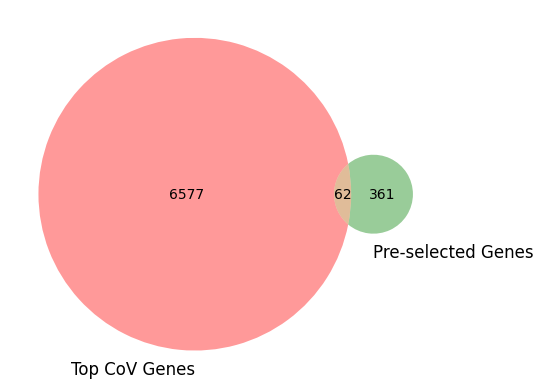

In [545]:

venn2([set(gene_df), set(regions_genes)], set_labels = ('Top CoV Genes', 'Pre-selected Genes'))
plt.show()

In [546]:
union_genes = np.union1d(gene_df, regions_genes)

len(union_genes)

7000

# Normalize data

In [547]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
X_unkp = X_full[idx_bulk,]
label_unkp = label_full[idx_bulk,]
bulk_unkp = bulk_full[idx_bulk,]
drug_unkp = drug_full[idx_bulk,]
y_unkp = Y_full.iloc[idx_bulk]
y_unkp = y_unkp.to_numpy()

# for known proportions
X_kp = X_full[idx_sc,]
label_kp = label_full[idx_sc,]
bulk_kp = bulk_full[idx_sc,]
drug_kp = drug_full[idx_sc,]
y_kp = Y_full.iloc[idx_sc]
y_kp = y_kp.to_numpy()


In [548]:
idx_sc

array([   0,    1,    2, ..., 4197, 4198, 4199])

In [549]:
y_kp

array([[0.21195761, 0.16016797, 0.01019796, ..., 0.18836233, 0.01419716,
        0.01019796],
       [0.10317936, 0.01059788, 0.064987  , ..., 0.14157169, 0.00419916,
        0.0309938 ],
       [0.00319936, 0.02439512, 0.67646471, ..., 0.13157369, 0.02559488,
        0.02939412],
       ...,
       [0.41671672, 0.02722723, 0.09802803, ..., 0.02965966, 0.11342342,
        0.00328328],
       [0.00775776, 0.04243243, 0.14974975, ..., 0.02057057, 0.31583584,
        0.04837838],
       [0.0855956 , 0.02      , 0.04627628, ..., 0.48292292, 0.01951952,
        0.06805806]])

In [550]:
y_unkp

array([[0.014997  , 0.00119976, 0.72265547, 0.00459908, 0.01419716,
        0.0089982 , 0.01279744, 0.0009998 , 0.08658268, 0.069986  ,
        0.04319136, 0.00319936, 0.01659668],
       [0.03      , 0.16      , 0.09      , 0.04      , 0.14      ,
        0.04      , 0.02      , 0.11      , 0.04      , 0.04      ,
        0.11      , 0.06      , 0.12      ],
       [0.04      , 0.01      , 0.06      , 0.01      , 0.01      ,
        0.02      , 0.02      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.78      ],
       [0.01257576, 0.00876768, 0.67473737, 0.01572727, 0.01353535,
        0.12109091, 0.01022222, 0.01531313, 0.05123232, 0.00363636,
        0.02042424, 0.00242424, 0.05031313],
       [0.28574285, 0.06078784, 0.00679864, 0.06958608, 0.02139572,
        0.01619676, 0.02279544, 0.01139772, 0.02459508, 0.0469906 ,
        0.00859828, 0.02419516, 0.40091982],
       [0.00752632, 0.01294737, 0.00784211, 0.08989474, 0.03242105,
        0.37447368, 0.045  

# Plot all data

In [551]:
meta_df

sample_id  \
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...  BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017...   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...  BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022...   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...  BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022...   
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...  BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005...   
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...  BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003...   
...                                                                                               ...   
BRCA_IC34 -1-0-0-0-0                                                                       BRCA_IC34    
BRCA_IC12 -1-0-0-0                                                                         BRCA_IC12    
BRCA_IC04 -1-0-0                                                                           BRCA_IC04    
LUNG_IC42 -1-0                                                                             LUNG_IC42    
LUNG_IC06 -0-1                                                                             LUNG_IC06    

                                                   cancer_type isTraining  \
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...       blood      Train   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       blood      Train   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       blood      Train   
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...       blood      Train   
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...       blood      Train   
...                                                        ...        ...   
BRCA_IC34 -1-0-0-0-0                                      BRCA      Train   
BRCA_IC12 -1-0-0-0                                        BRCA      Train   
BRCA_IC04 -1-0-0                                          BRCA      Train   
LUNG_IC42 -1-0                                            LUNG      Train   
LUNG_IC06 -0-1                                            LUNG      Train   

                                                    num_blood samp_type  Y_max  
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...       5001        sc  blood  
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       5001        sc  blood  
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       5001        sc  blood  
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...       5001        sc  blood  
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...       5001        sc  blood  
...                                                       ...       ...    ...  
BRCA_IC34 -1-0-0-0-0                                        0      bulk   BRCA  
BRCA_IC12 -1-0-0-0                                          0      bulk   BRCA  
BRCA_IC04 -1-0-0                                            0      bulk   BRCA  
LUNG_IC42 -1-0                                              0      bulk   LUNG  
LUNG_IC06 -0-1                                              0      bulk   LUNG  

[4206 rows x 6 columns]

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...


[t-SNE] Computed neighbors for 10000 samples in 2.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.344075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.275787
[t-SNE] KL divergence after 500 iterations: 1.106522
(10000, 2)
(10000, 2)


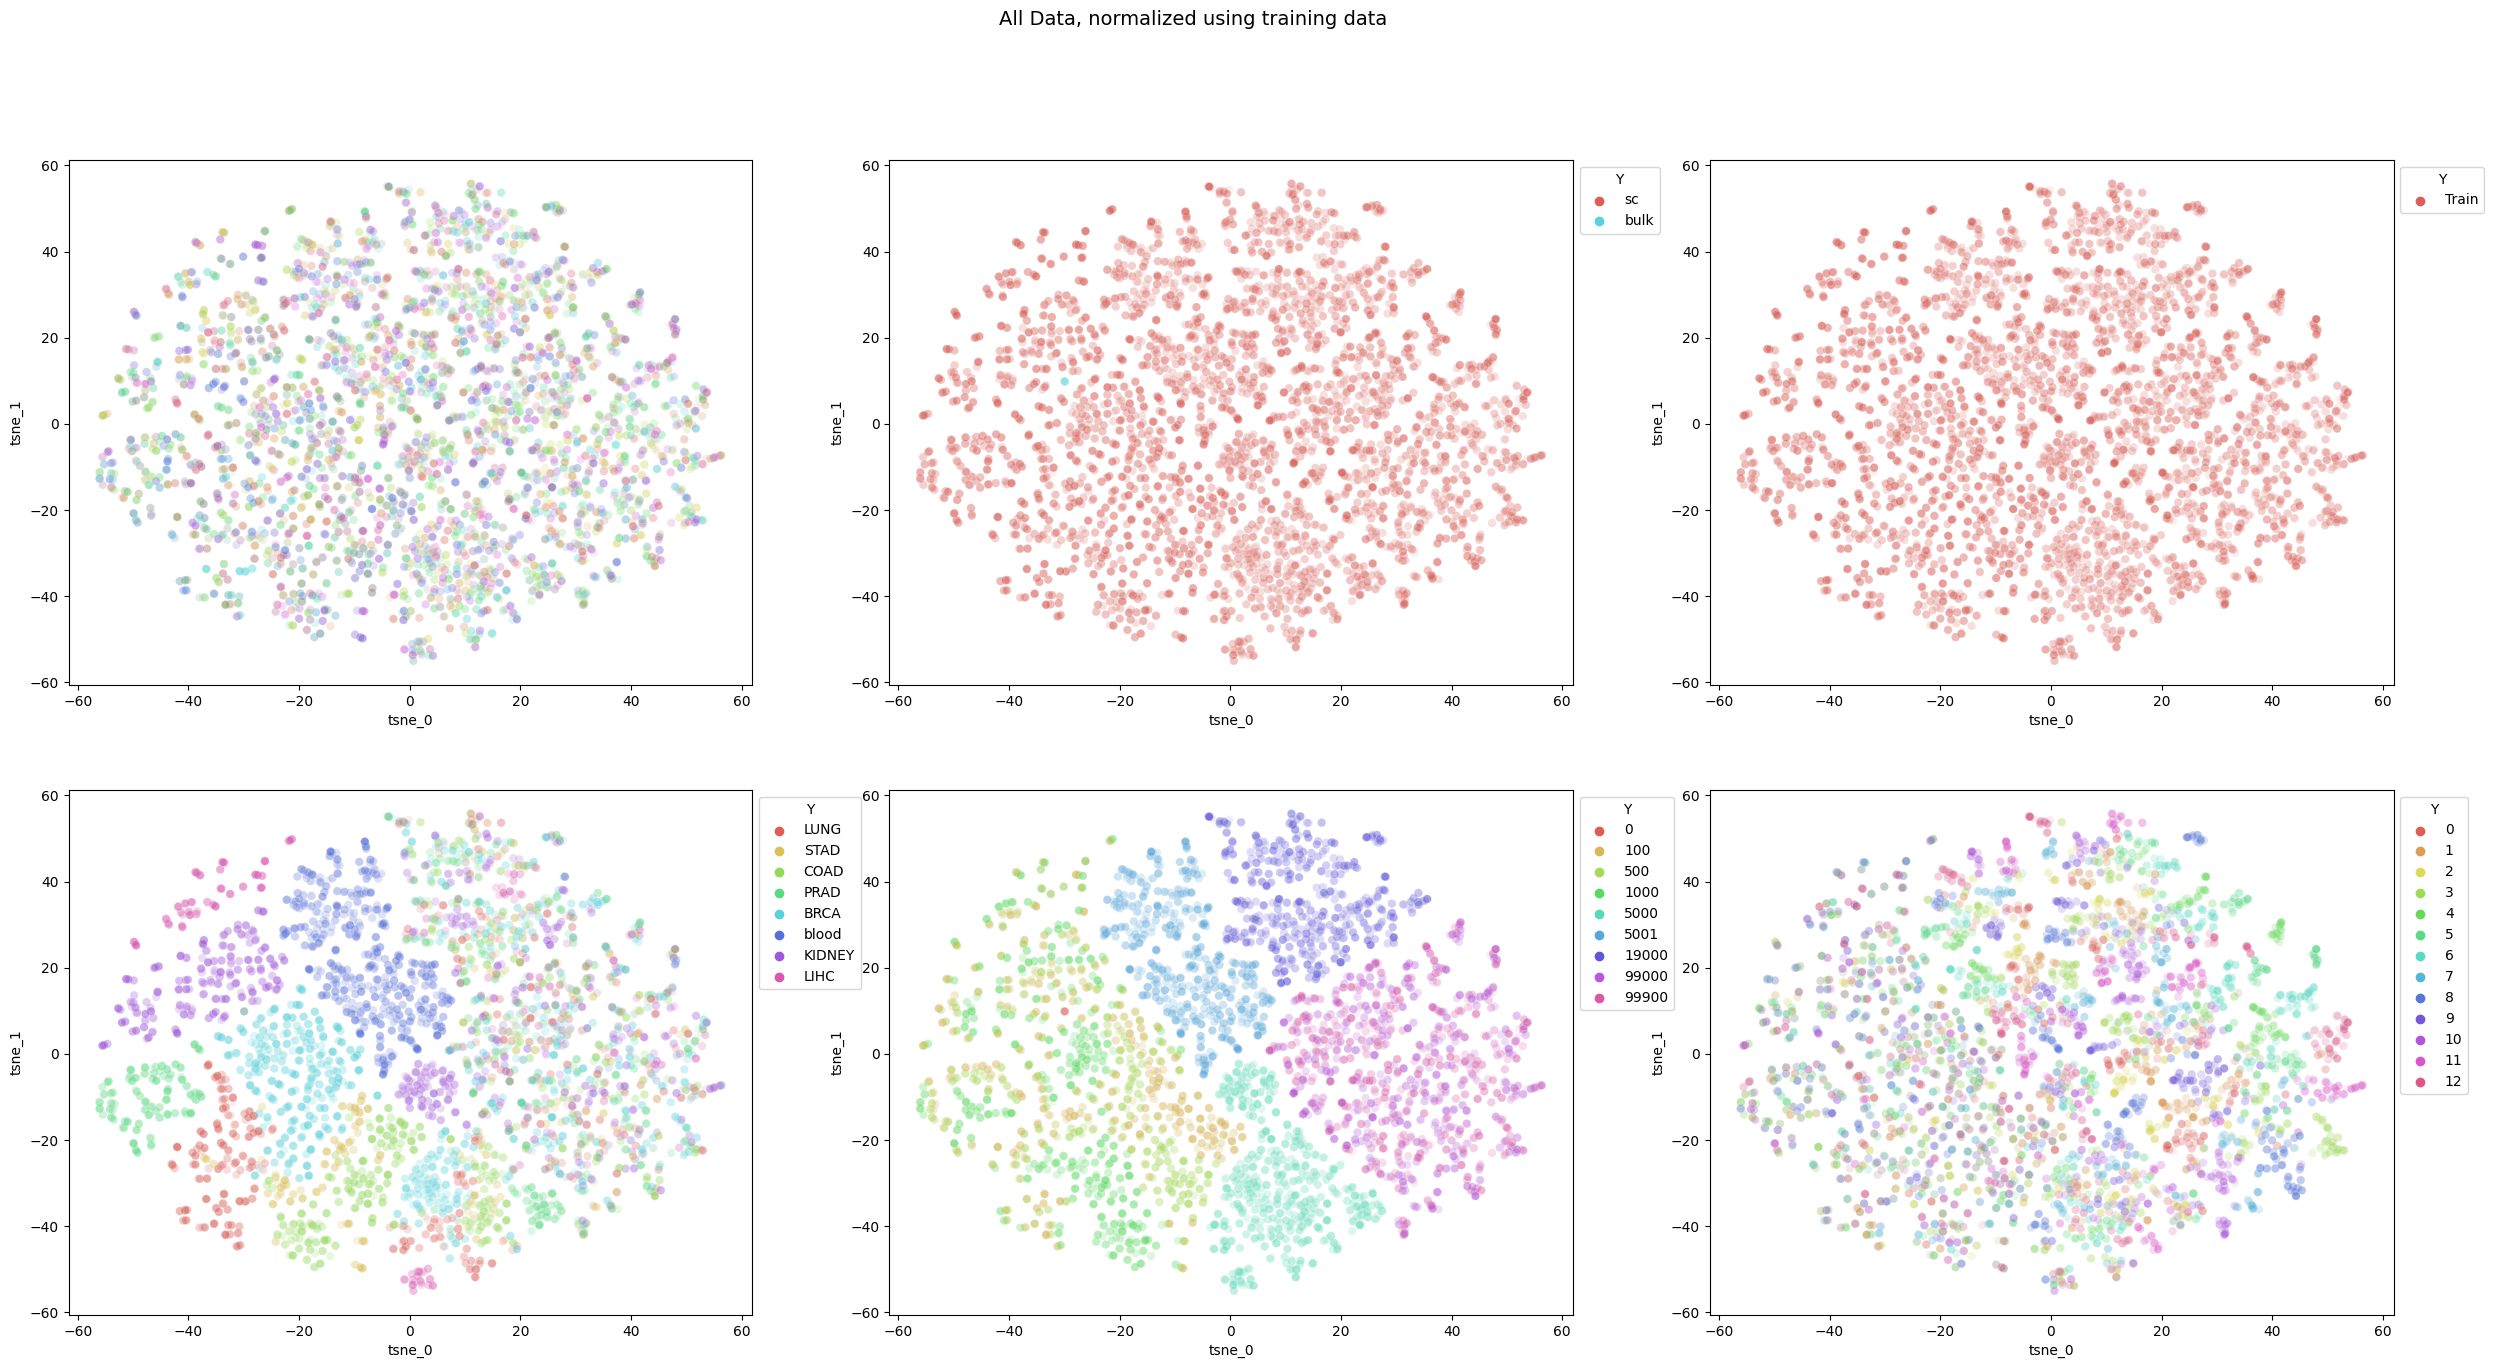

In [552]:
## plot samples
idx_tmp = np.random.choice(range(X_full.shape[0]), 10000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].samp_type.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cancer_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].num_blood.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run BuDDI**

## Hyperparameter Search

We are going to search over 2 parameters: 

1.  the weighting of the loss for the latent space classifications against the reconstruction (100, 1000, 10000)
2.  the number of epochs  (50, 100, 200)

2024-04-19 22:08:14.822148: W tensorflow/c/c_api.cc:304] Operation '{name:'mu_drug_24/kernel/Assign' id:61007 op device:{requested: '', assigned: ''} def:{{{node mu_drug_24/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mu_drug_24/kernel, mu_drug_24/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-19 22:08:16.418463: W tensorflow/c/c_api.cc:304] Operation '{name:'z_samp_slack_13/truediv/y' id:61167 op device:{requested: '', assigned: ''} def:{{{node z_samp_slack_13/truediv/y}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-19 22:08:17.555455: W tensorflow/c/c_api.cc:304] Operation '{name:'z_samp_rot_13/random_normal' id:61179 op device:{requested: '', assigned: ''} def:{{{node z_samp_rot_13/random_normal}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](z_samp_rot_13/random_normal/mul, z_samp_rot_13/random_normal/mean)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify 

test_size_samp: 500
train_size_samp: 4500


2024-04-19 22:08:26.265918: W tensorflow/c/c_api.cc:304] Operation '{name:'training_44/Adam/sigma_bulk_33/kernel/m/Assign' id:62870 op device:{requested: '', assigned: ''} def:{{{node training_44/Adam/sigma_bulk_33/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_44/Adam/sigma_bulk_33/kernel/m, training_44/Adam/sigma_bulk_33/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-19 22:08:34.065329: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_27/AddN' id:61963 op device:{requested: '', assigned: ''} def:{{{node loss_27/AddN}} = AddN[N=4, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_27/mul, loss_27/mul_1, loss_27/mul_2, loss_27/mul_3)}}' was changed by setting attribute after it was run by a session. This 

Elapsed:  736.0147514343262
Epoch:  199
INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_known_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_known_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_unlab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_unlab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_lab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_lab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_decoder/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_decoder/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_classifier/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_classifier/assets


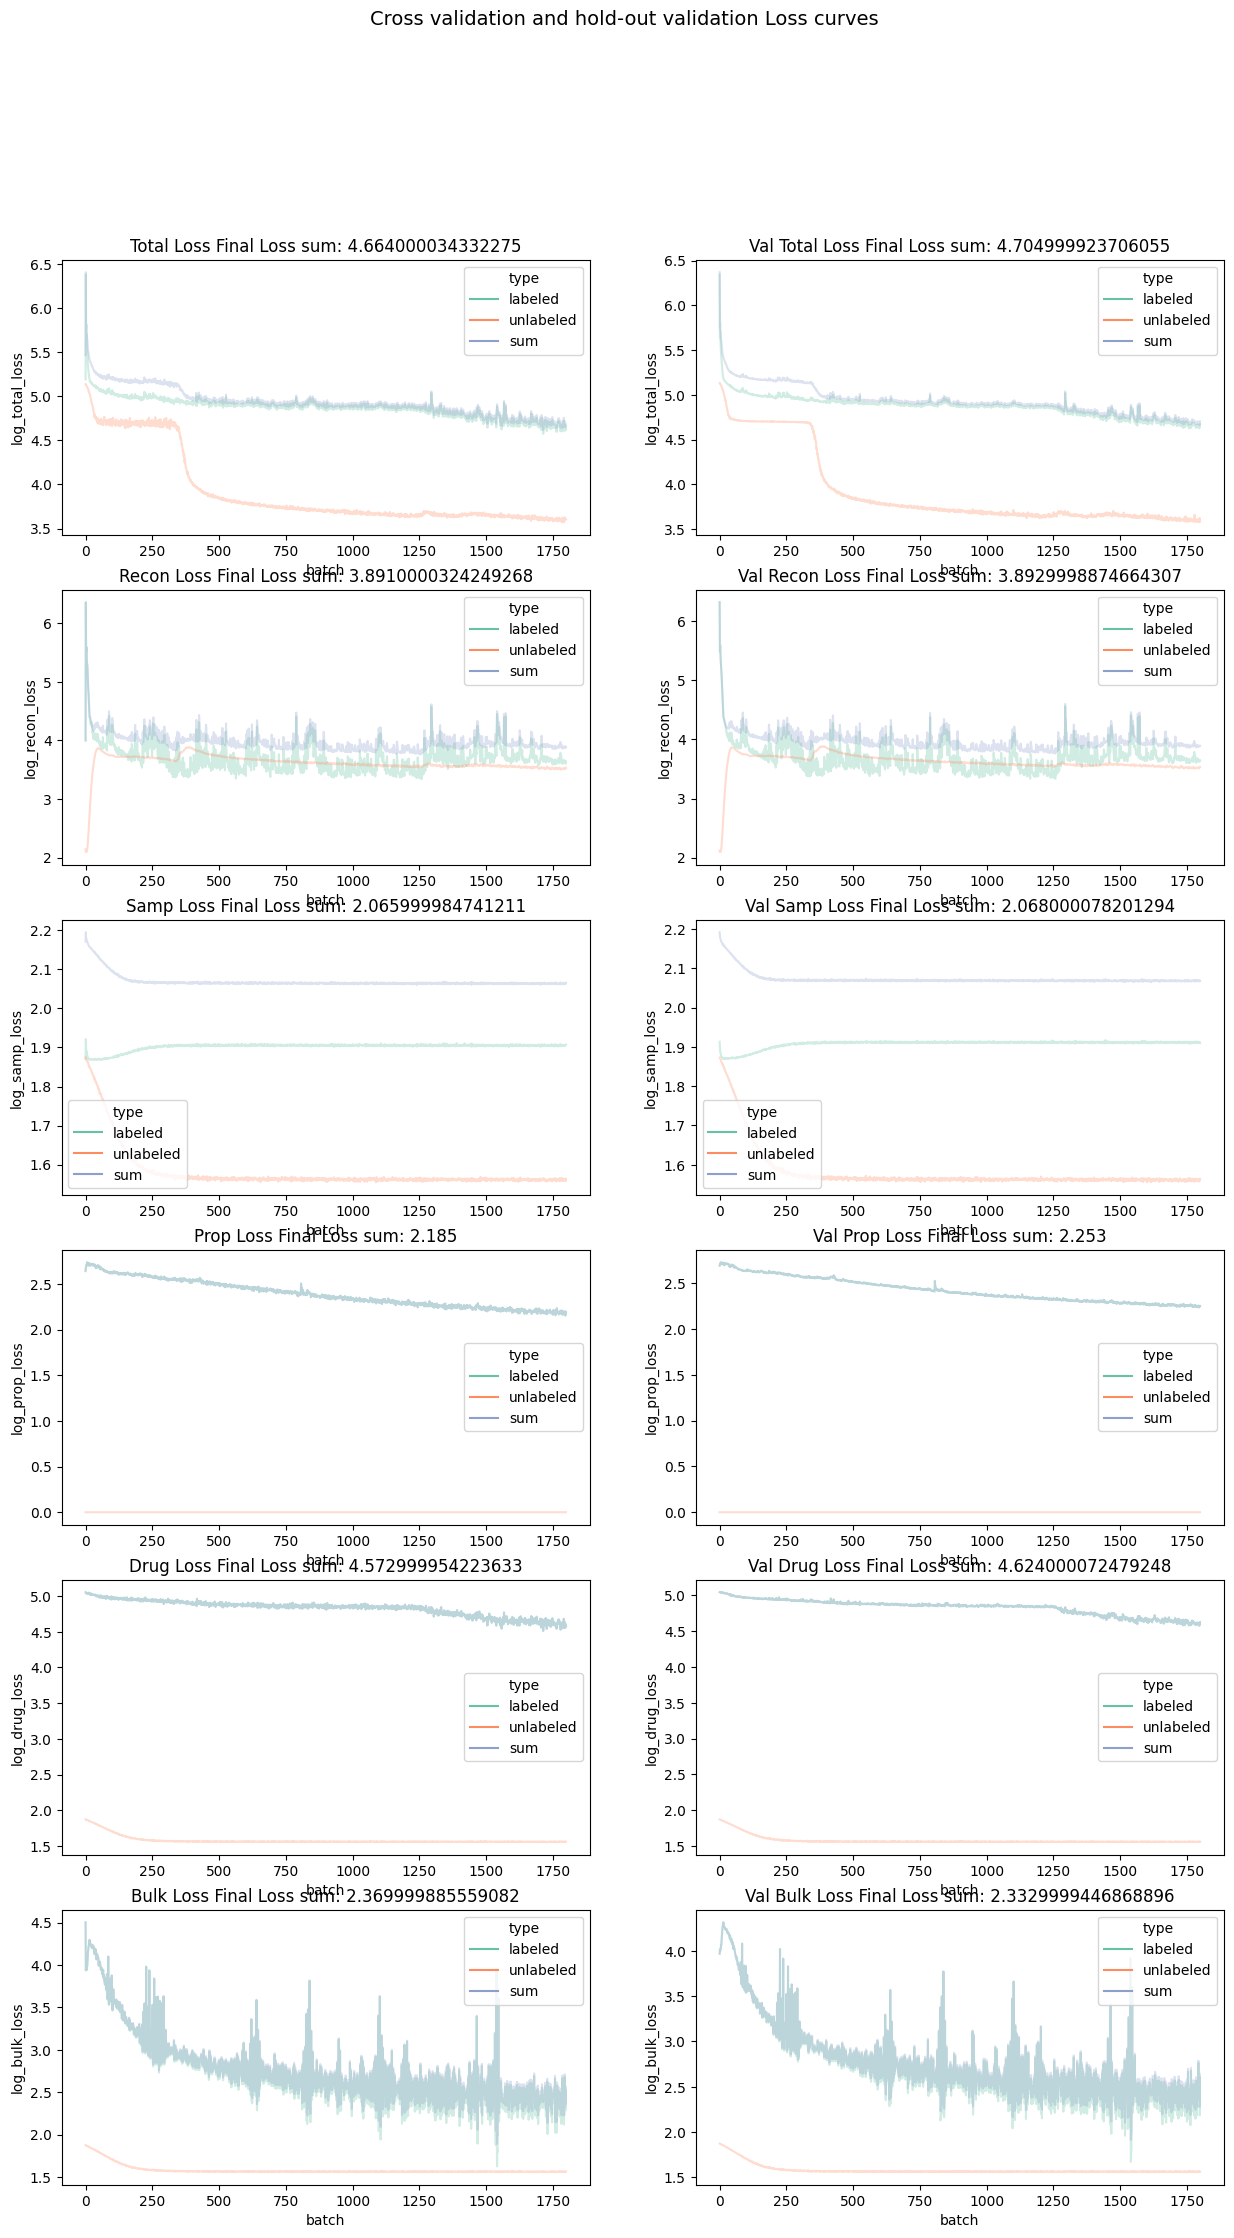

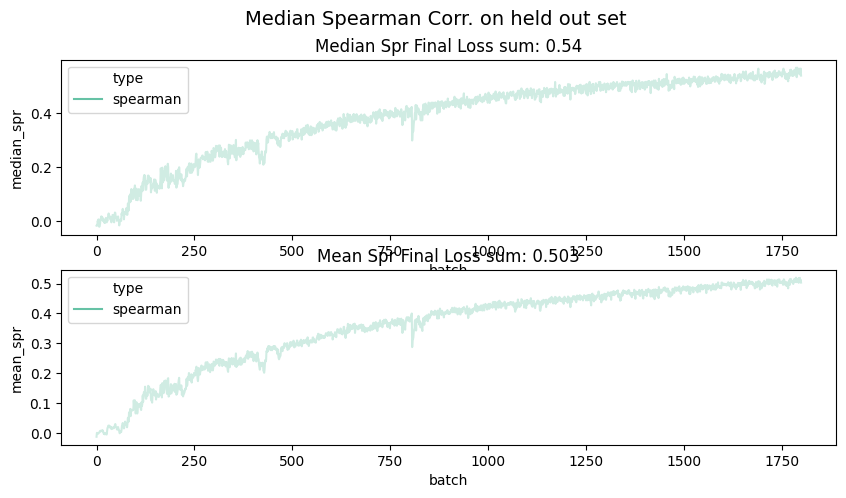

In [554]:
curr_n_epoch=200
curr_wt = 10

params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt*10, alpha_drug=curr_wt*100)


curr_res_id = f"{res_id}"
res = buddi.train_buddi(res_data_path, curr_res_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)


## visualize latent spaces

In [555]:
Y_full

CD4+ naïve T  CD4+ memory T  CD8+ naïve T        NK  CD14 mono  CD16 mono  \
0       0.211958       0.160168      0.010198  0.050390   0.008198   0.006999   
0       0.103179       0.010598      0.064987  0.033793   0.008798   0.398120   
0       0.003199       0.024395      0.676465  0.021996   0.016997   0.018796   
0       0.045591       0.200160      0.053989  0.045791   0.037193   0.016997   
0       0.007199       0.014797      0.068186  0.014397   0.001400   0.107179   
..           ...            ...           ...       ...        ...        ...   
0       0.030000       0.160000      0.090000  0.040000   0.140000   0.040000   
0       0.040000       0.010000      0.060000  0.010000   0.010000   0.020000   
0       0.012576       0.008768      0.674737  0.015727   0.013535   0.121091   
0       0.285743       0.060788      0.006799  0.069586   0.021396   0.016197   
0       0.007526       0.012947      0.007842  0.089895   0.032421   0.374474   

    intermediate mono  memory B      MAIT  CD8+ activated T   naïve B  \
0            0.004199  0.017596  0.314537          0.002999  0.188362   
0            0.000600  0.019196  0.004399          0.179564  0.141572   
0            0.002200  0.002599  0.027195          0.019596  0.131574   
0            0.004199  0.058188  0.026595          0.006199  0.002000   
0            0.106379  0.457109  0.035393          0.054589  0.097381   
..                ...       ...       ...               ...       ...   
0            0.020000  0.110000  0.040000          0.040000  0.110000   
0            0.020000  0.010000  0.010000          0.010000  0.010000   
0            0.010222  0.015313  0.051232          0.003636  0.020424   
0            0.022795  0.011398  0.024595          0.046991  0.008598   
0            0.045000  0.017316  0.120211          0.087368  0.012474   

         pDC       mDC  
0   0.014197  0.010198  
0   0.004199  0.030994  
0   0.025595  0.029394  
0   0.473705  0.029394  
0   0.002599  0.033393  
..       ...       ...  
0   0.060000  0.120000  
0   0.010000  0.780000  
0   0.002424  0.050313  
0   0.024195  0.400920  
0   0.006895  0.185632  

[4206 rows x 13 columns]

In [556]:
cancer_df

BRCA  COAD  KIDNEY  LIHC  LUNG  PRAD  STAD  blood
0        0     0       0     0     0     0     0      1
1        0     0       0     0     0     0     0      1
2        0     0       0     0     0     0     0      1
3        0     0       0     0     0     0     0      1
4        0     0       0     0     0     0     0      1
...    ...   ...     ...   ...   ...   ...   ...    ...
4201     1     0       0     0     0     0     0      0
4202     1     0       0     0     0     0     0      0
4203     1     0       0     0     0     0     0      0
4204     0     0       0     0     1     0     0      0
4205     0     0       0     0     1     0     0      0

[4206 rows x 8 columns]

In [557]:
meta_df

sample_id  \
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...  BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017...   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...  BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022...   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...  BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022...   
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...  BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005...   
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...  BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003...   
...                                                                                               ...   
BRCA_IC34 -1-0-0-0-0                                                                       BRCA_IC34    
BRCA_IC12 -1-0-0-0                                                                         BRCA_IC12    
BRCA_IC04 -1-0-0                                                                           BRCA_IC04    
LUNG_IC42 -1-0                                                                             LUNG_IC42    
LUNG_IC06 -0-1                                                                             LUNG_IC06    

                                                   cancer_type isTraining  \
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...       blood      Train   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       blood      Train   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       blood      Train   
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...       blood      Train   
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...       blood      Train   
...                                                        ...        ...   
BRCA_IC34 -1-0-0-0-0                                      BRCA      Train   
BRCA_IC12 -1-0-0-0                                        BRCA      Train   
BRCA_IC04 -1-0-0                                          BRCA      Train   
LUNG_IC42 -1-0                                            LUNG      Train   
LUNG_IC06 -0-1                                            LUNG      Train   

                                                    num_blood samp_type  Y_max  
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...       5001        sc  blood  
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       5001        sc  blood  
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       5001        sc  blood  
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...       5001        sc  blood  
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...       5001        sc  blood  
...                                                       ...       ...    ...  
BRCA_IC34 -1-0-0-0-0                                        0      bulk   BRCA  
BRCA_IC12 -1-0-0-0                                          0      bulk   BRCA  
BRCA_IC04 -1-0-0                                            0      bulk   BRCA  
LUNG_IC42 -1-0                                              0      bulk   LUNG  
LUNG_IC06 -0-1                                              0      bulk   LUNG  

[4206 rows x 6 columns]

In [559]:
# read in models

res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_classifier")
res1_unk_prop_vae = res.unknown_prop_vae




2024-04-19 22:20:58.046276: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_759' id:65947 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_759}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_275, Identity_7037)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-19 22:21:03.863464: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_776' id:66316 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_776}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_294, Identity_7054)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-19 22:21:06.782516: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_799' id:66508 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_799}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_297, Identity_7077)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-19 22:21:09.638334: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_802' id:66591 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_802}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_299, Identity_7080)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### plot data

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-19 22:21:11.291308: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack_13/add/z_samp_slack_13/add' id:66044 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack_13/add/z_samp_slack_13/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies=true](mu_slack_34/BiasAdd, tf_op_layer_z_samp_slack_13/mul/z_samp_slack_13/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-19 22:21:12.871900: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out_24/

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


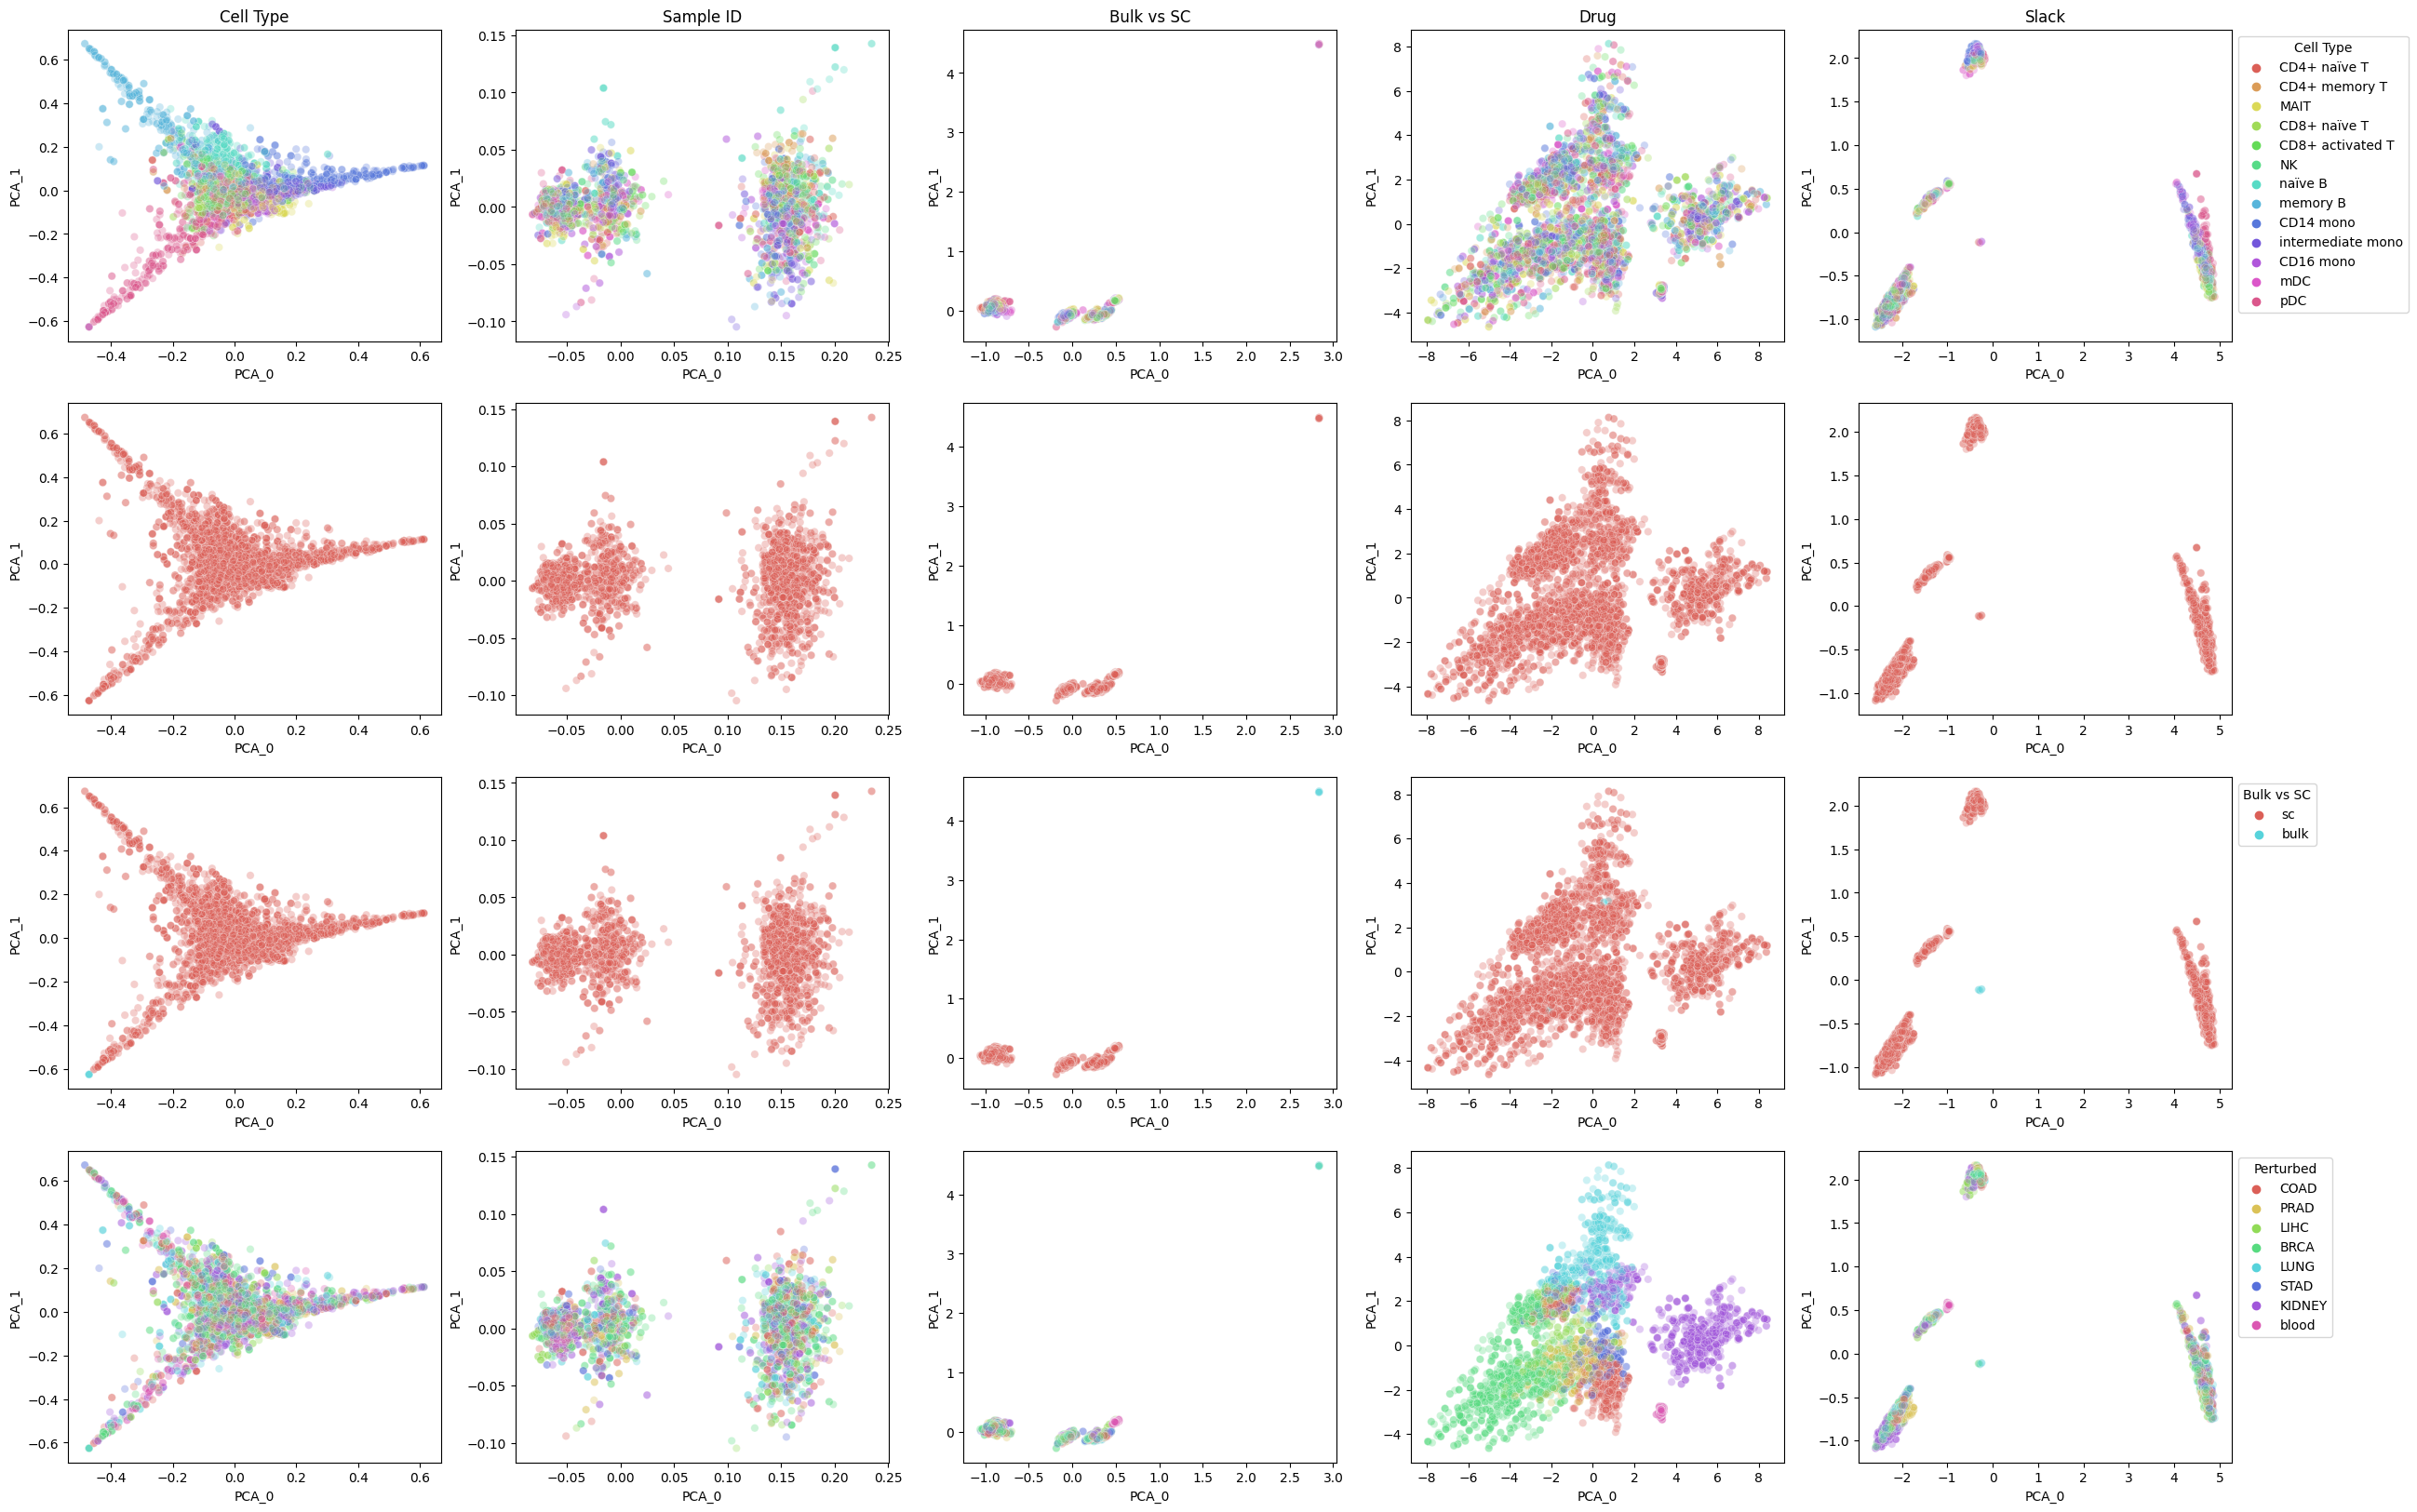

In [560]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

idx_tmp = np.where(np.logical_or(meta_df.cancer_type == "BRCA", meta_df.cancer_type == "LUNG"))[0]
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[[0]*5000]


drug_temp = np.copy(Drug_full)
drug_temp = drug_temp[idx_tmp]
drug_temp = index_drug[drug_temp]

bulk_temp =np.copy(meta_df.samp_type)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, drug_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True, hide_sample_ids=True, alpha=0.3)

In [561]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


In [562]:
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
len(idx_tmp)

4206

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-19 22:21:18.398529: W tensorflow/c/c_api.cc:304] Operation '{name:'decoder_out_51/Sigmoid' id:61324 op device:{requested: '', assigned: ''} def:{{{node decoder_out_51/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder_out_51/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


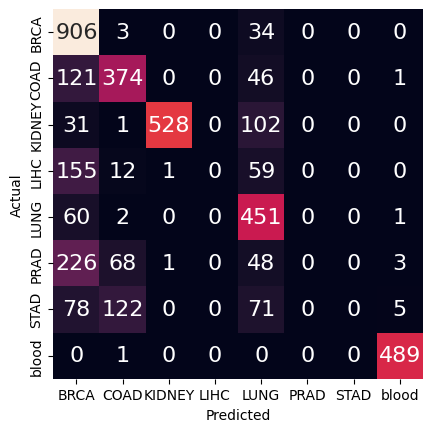

In [563]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_len = len(idx_tmp)
idx_tmp = np.append(idx_tmp, idx_tmp)[0:8000]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


_, _, ct_pred, _ = res1_unk_prop_vae.predict(X_temp, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)[0:idx_len]
ct_true = perturb_temp[0:idx_len]
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [564]:
print(classification_report(ct_true, ct_pred))

              precision    recall  f1-score   support

           0       0.57      0.96      0.72       943
           1       0.64      0.69      0.66       542
           2       1.00      0.80      0.89       662
           3       0.00      0.00      0.00       227
           4       0.56      0.88      0.68       514
           5       0.00      0.00      0.00       346
           6       0.00      0.00      0.00       276
           7       0.98      1.00      0.99       490

    accuracy                           0.69      4000
   macro avg       0.47      0.54      0.49      4000
weighted avg       0.58      0.69      0.61      4000



/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

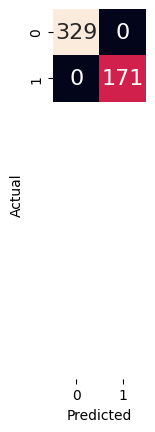

In [565]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(meta_df.samp_type == "bulk")[0]
idx_tmp = np.random.choice(idx_tmp, 500, replace=True)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


_, _, ct_pred, _ = res1_unk_prop_vae.predict(X_temp, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)
ct_true = perturb_temp
labels = index_drug[[0, 1, 2]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [568]:
print(classification_report(ct_true, ct_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           4       1.00      1.00      1.00       171

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



# now classify the unseen cfDNA

In [569]:
# now test

# format into dataframe
cfdna_X = pd.DataFrame(cfdna_test.X.todense())
cfdna_X.columns = cfdna_test.var.gene_ids
cfdna_X = cfdna_X[union_genes]


# make metadata table
meta_cfdna_test = cfdna_test.obs
meta_cfdna_test = meta_cfdna_test[["sample_id", "cancer_type"]]
meta_cfdna_test["isTraining"] = "Train"
meta_cfdna_test["num_blood"] = 0
meta_cfdna_test["samp_type"] = "bulk"


# repeat 500 times for batch size
idx_tmp = np.random.choice([0,1,2], 500, replace=True)
X_cf = np.copy(cfdna_X)
X_cf = X_cf[idx_tmp,]


Y_cfdna_test = Y_test.iloc[np.random.choice(range(Y_test.shape[0]), cfdna_X.shape[0])]
Y_temp = np.copy(Y_cfdna_test)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
#Y_temp = cancer_df.columns[Y_temp]


label_cf = index_label[[0]*500]
drug_cf = meta_cfdna_test.cancer_type.iloc[idx_tmp]
bulk_cf = [99900]*500

## normalize within sample
X_cf = np.clip(X_cf, 0, clip_upper)

# now normalize with the scaler trained on the 
# training data
X_cf = scaler.transform(X_cf)




/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [570]:
ct_true = cfdna_test.obs.iloc[idx_tmp].cancer_type.astype(str)
ct_true[np.where(ct_true == "BRCA")[0]] = 0
ct_true[np.where(ct_true == "LUNG")[0]] = 4
ct_true = ct_true.tolist()

In [571]:
# now predict

_, _, ct_pred, _ = res1_unk_prop_vae.predict(X_cf, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)


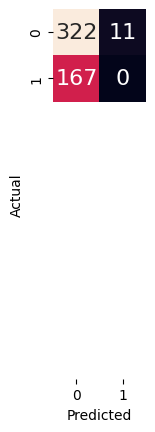

In [574]:


cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [576]:
print(classification_report(ct_true, ct_pred))

              precision    recall  f1-score   support

           0       0.66      0.97      0.78       333
           4       0.00      0.00      0.00       167

    accuracy                           0.64       500
   macro avg       0.33      0.48      0.39       500
weighted avg       0.44      0.64      0.52       500



In [579]:
# make the original DF
idx_tmp = np.where(np.logical_or(meta_df.cancer_type == "BRCA", meta_df.cancer_type == "LUNG"))[0]
idx_tmp = np.where(meta_df.samp_type == "bulk")[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

drug_temp = np.copy(Drug_full)
drug_temp = drug_temp[idx_tmp]
drug_temp = index_drug[drug_temp]

# make the cfDNA DF

# format into dataframe
cfdna_X = pd.DataFrame(cfdna_test.X.todense())
cfdna_X.columns = cfdna_test.var.gene_ids
cfdna_X = cfdna_X[union_genes]


# make metadata table
meta_cfdna_test = cfdna_test.obs
meta_cfdna_test = meta_cfdna_test[["sample_id", "cancer_type"]]
meta_cfdna_test["isTraining"] = "Train"
meta_cfdna_test["num_blood"] = 0
meta_cfdna_test["samp_type"] = "bulk"


# repeat 500 times for batch size
idx_tmp = np.random.choice([0,1,2], 500, replace=True)
X_cf = np.copy(cfdna_X)
X_cf = X_cf[idx_tmp,]

## normalize within sample
X_cf = np.clip(X_cf, 0, clip_upper)

# now normalize with the scaler trained on the 
# training data
X_cf = scaler.transform(X_cf)


drug_cf = meta_cfdna_test.cancer_type.iloc[idx_tmp].tolist()


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(5500, 2)
(5500, 2)


<AxesSubplot: xlabel='PCA_0', ylabel='PCA_1'>

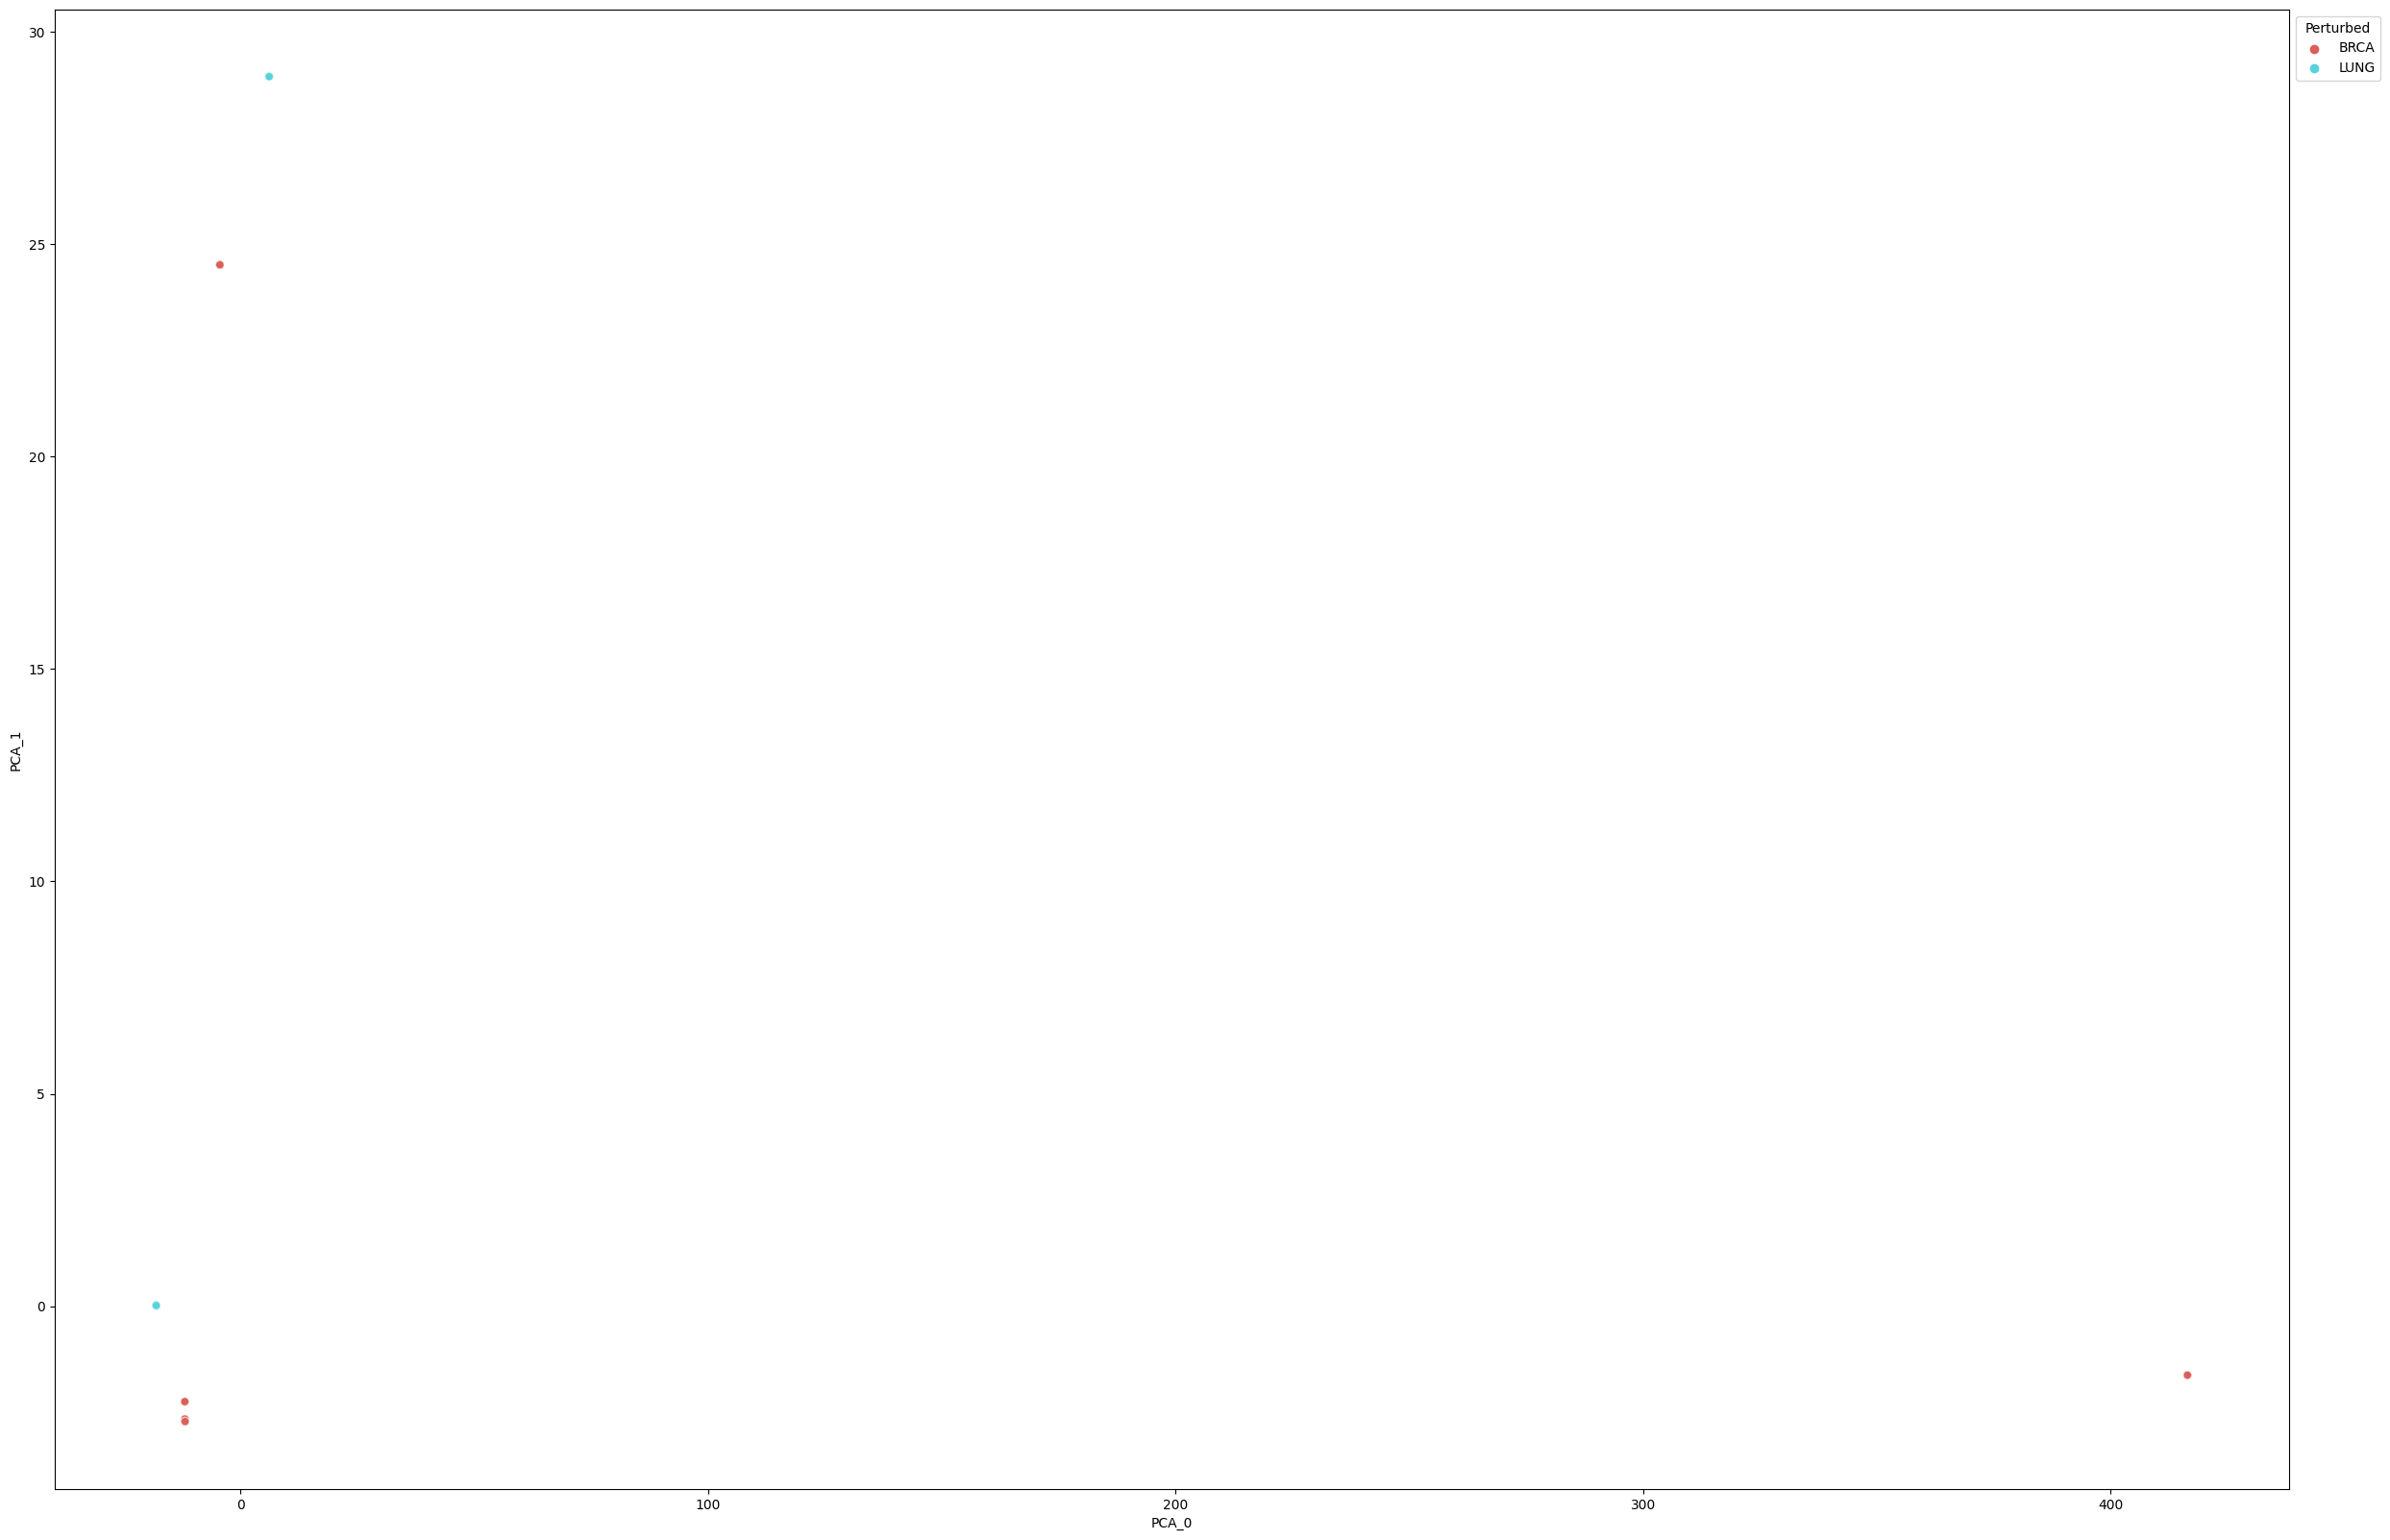

In [581]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

X_cf = np.concatenate([X_temp, X_cf], axis=0)
drug_cf = drug_temp.tolist() + drug_cf

z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _ = res1_enc_unlab.predict(X_cf, batch_size=500)

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
fig, axs = plt.subplots(figsize=(10,10))

vp.plot_pca(plot_df, color_vec=drug_cf, ax=axs, title="", alpha=0.3, legend_title="Perturbed")
